In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
dt = pd.read_csv("F:/Kaggle/Pakistan Largest Ecommerce Dataset.csv")
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   item_id                584524 non-null  float64
 1   status                 584509 non-null  object 
 2   created_at             584524 non-null  object 
 3   sku                    584504 non-null  object 
 4   price                  584524 non-null  float64
 5   qty_ordered            584524 non-null  float64
 6   grand_total            584524 non-null  float64
 7   increment_id           584524 non-null  object 
 8   category_name_1        584360 non-null  object 
 9   sales_commission_code  447349 non-null  object 
 10  discount_amount        584524 non-null  float64
 11  payment_method         584524 non-null  object 
 12  Working Date           584524 non-null  object 
 13  BI Status              584524 non-null  object 
 14   MV                    584524 non-

In [64]:
#保留需要的columns，並且刪除整行是空值的欄位
dt = dt.loc[:,["item_id", "status", "created_at", "sku", "price", "qty_ordered", "grand_total", "category_name_1","discount_amount", \
    "payment_method", "Year", "Month", "Customer ID"]]
dt = dt.dropna(how = 'all')

In [65]:
dt.describe()

,item_id,price,qty_ordered,grand_total,discount_amount,Year,Month,Customer ID
count,584524.000000,5.845240e+05,584524.000000,5.845240e+05,584524.000000,584524.000000,584524.000000,584513.000000
mean,565667.074218,6.348748e+03,1.296388,8.530619e+03,499.492775,2017.044115,7.167654,45790.511965
std,200121.173648,1.494927e+04,3.996061,6.132081e+04,1506.943046,0.707355,3.486305,34414.962389
min,211131.000000,0.000000e+00,1.000000,-1.594000e+03,-599.500000,2016.000000,1.000000,1.000000
25%,395000.750000,3.600000e+02,1.000000,9.450000e+02,0.000000,2017.000000,4.000000,13516.000000
50%,568424.500000,8.990000e+02,1.000000,1.960400e+03,0.000000,2017.000000,7.000000,42856.000000
75%,739106.250000,4.070000e+03,1.000000,6.999000e+03,160.500000,2018.000000,11.000000,73536.000000
max,905208.000000,1.012626e+06,1000.000000,1.788800e+07,90300.000000,2018.000000,12.000000,115326.000000


In [66]:
dt.describe(include=['object','bool'])

,status,created_at,sku,category_name_1,payment_method
count,584509,584524,584504,584360,584524
unique,16,789,84889,16,18
top,complete,11/25/2016,MATSAM59DB75ADB2F80,Mobiles & Tablets,cod
freq,233685,15169,3775,115710,271960


Insights:
- grand_total欄位代表營收，最小值是負值可能數據有誤，接下來確認這些異常訂單與訂單狀態的關係。
- status 訂單狀態有16種，需要再進一步做整理。

Text(0, 0.5, 'Counts')

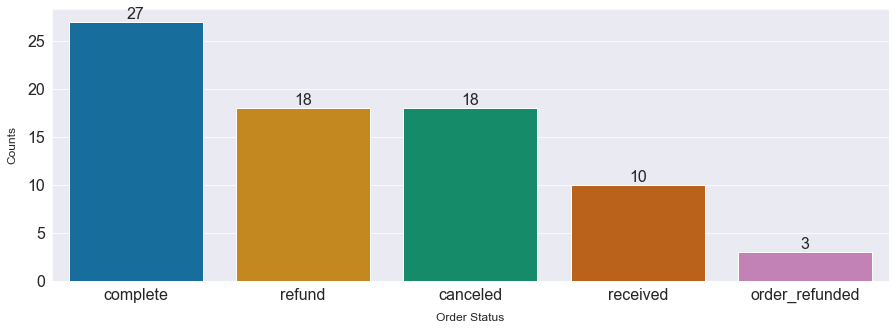

In [67]:
grand_total_check = dt[dt["grand_total"] < 0]["status"].value_counts().rename_axis("status").reset_index(name="counts")
#grand_total_check

fig, ax = plt.subplots(figsize=(15,5))
sns.set_style("darkgrid")
g = sns.barplot(data=grand_total_check, x="status", y="counts", palette="colorblind")
ax.bar_label(g.containers[0], padding = 0, fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Order Status', fontsize=12, labelpad=10)
plt.ylabel('Counts', fontsize=12, labelpad=10)

Insights:
上表grand_total為負值的76筆訂單在每個狀態都有出現，沒有顯示具備特別意義，所以將這些異常資料移除。

In [68]:
dt = dt[dt["grand_total"] >= 0]

In [69]:
#檢查 status 內不同的分類，接著把意思相近的分類整理成 "已完成"、"取消"、"處理中"
dt["status"].unique()

array(['complete', 'canceled', 'order_refunded', 'received', 'refund',
       'closed', 'fraud', 'holded', 'exchange', 'pending_paypal', 'paid',
       '\\N', 'cod', 'pending', nan, 'processing', 'payment_review'],
      dtype=object)

In [70]:
dt["status"] = dt["status"].replace(
    {"complete": "completed",
    "received": "completed",
    "cod": "completed",
    "paid": "completed",
    "closed": "completed",
    "exchange": "completed",
    "canceled": "canceled",
    "order_refunded": "canceled",
    "refund": "canceled",
    "fraud": "canceled",
    "payment_review": "pending",
    "pending": "pending",
    "processing": "pending",
    "holded": "pending",
    "pending_paypal": "pending"})

In [71]:
#將部分columns轉換成正確的資料類型
dt['Customer ID'] = dt['Customer ID'].astype(str)
dt['item_id'] = dt['item_id'].astype(str)
dt['qty_ordered'] = dt['qty_ordered'].astype(int)  
dt['Year'] = dt['Year'].astype(int)  
dt['Month'] = dt['Month'].astype(int)

In [72]:
#將消費日期轉為正確格式 %Y/%m/%m
dt["Day"] = dt["created_at"].str.split('/', expand=True)[1].apply(lambda x: x if len(x)>1 else "0"+x)
dt["Month"] = dt["Month"].astype(str).apply(lambda x: x if len(x)>1 else "0"+x)
dt["created_at"] = dt["Year"].astype(str) + "-" + dt["Month"] + "-" + dt["Day"].astype(str)
dt["created_at_date"] = pd.to_datetime(dt["created_at"])
print(dt["created_at_date"].min())
print(dt["created_at_date"].max())

2016-07-01 00:00:00
2018-08-28 00:00:00


In [73]:
#1: 計算2016/07/01 - 2018/08/28 月營收
revenue = dt[dt["status"] == "completed"][["Year", "Month", "qty_ordered", "grand_total"]].groupby(["Year", "Month"]).agg('sum').sort_values(by=["Year", "Month"]).reset_index()
created_at_y_m = revenue["Year"].astype(str) + "-" + revenue["Month"]
revenue.insert(0,"Year_Month",created_at_y_m)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, '2016-07'),
  Text(1, 0, '2016-08'),
  Text(2, 0, '2016-09'),
  Text(3, 0, '2016-10'),
  Text(4, 0, '2016-11'),
  Text(5, 0, '2016-12'),
  Text(6, 0, '2017-01'),
  Text(7, 0, '2017-02'),
  Text(8, 0, '2017-03'),
  Text(9, 0, '2017-04'),
  Text(10, 0, '2017-05'),
  Text(11, 0, '2017-06'),
  Text(12, 0, '2017-07'),
  Text(13, 0, '2017-08'),
  Text(14, 0, '2017-09'),
  Text(15, 0, '2017-10'),
  Text(16, 0, '2017-11'),
  Text(17, 0, '2017-12'),
  Text(18, 0, '2018-01'),
  Text(19, 0, '2018-02'),
  Text(20, 0, '2018-03'),
  Text(21, 0, '2018-04'),
  Text(22, 0, '2018-05'),
  Text(23, 0, '2018-06'),
  Text(24, 0, '2018-07'),
  Text(25, 0, '2018-08')])

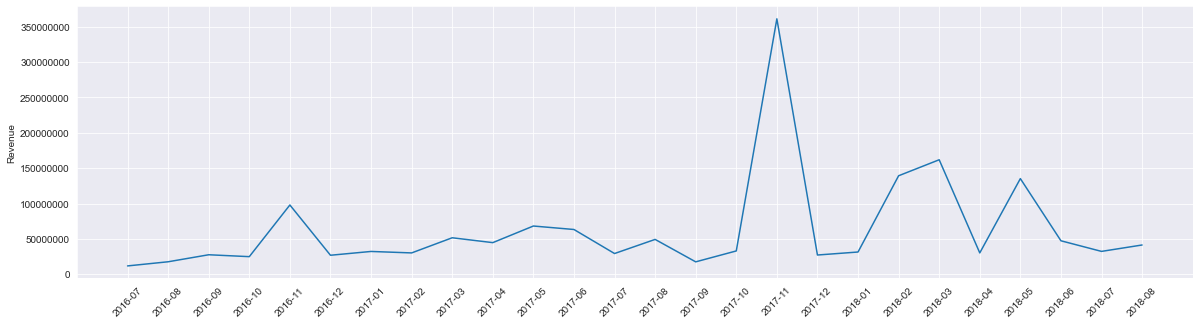

In [74]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.lineplot(data=revenue, x="Year_Month", y="grand_total")
ax.yaxis.get_major_formatter().set_scientific(False)
#ax.yaxis.get_major_formatter().set_useOffset(False)
ax.set_xlabel('')
ax.set_ylabel('Revenue')
plt.xticks(rotation=45)

人均訂單數、客單價


In [75]:
# shop_sum = revenue.groupby("invoice_date_y")["price"].agg("sum")
# customer_id_count = df.groupby("invoice_date_y")["invoice_no","customer_id"].nunique()
# customer_id_count
# shop_per_num =pd.concat([shop_sum,customer_id_count],axis=1)
# shop_per_num

In [76]:
#order_data = pd.merge(df_orders, df_order_payments, on="order_id")
# order_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y").agg("count")
# customer_id_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y")["customer_id"].nunique()
# order_count

使用 customer_unique_id 辨識消費者是否為新舊客。
消費人數(分新舊客)

In [77]:
#2016 - 2018 人均訂單數
# customer_id
# order_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y").agg("count")
# customer_id_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y")["customer_id"].nunique()
# order_count


In [78]:
# customer_id_count